# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
import os


In [17]:
class Config():
    training_dir = "./train/"
    testing_dir = "./test/"
    train_batch_size = 64
    train_number_epochs = 2000

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [7]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
0 indiciates dissimilar, and 1 indicates similar.

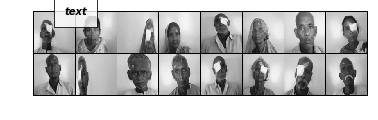

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]]


Process Process-8:
Process Process-1:
Process Process-6:
Process Process-2:
Process Process-5:
Process Process-3:
Process Process-7:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/nishant/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/nishant/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/nishant/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/nishant/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/nishant/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/nishant/anaconda3/lib/python3.6

In [8]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated), 'text')
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(16*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [11]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [12]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [13]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.001 )

In [14]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.6852672100067139

Epoch number 1
 Current loss 1.143250823020935

Epoch number 2
 Current loss 1.439818024635315

Epoch number 3
 Current loss 1.4302685260772705

Epoch number 4
 Current loss 1.8788113594055176

Epoch number 5
 Current loss 1.1168612241744995

Epoch number 6
 Current loss 1.148118495941162

Epoch number 7
 Current loss 1.2371524572372437

Epoch number 8
 Current loss 1.1643539667129517

Epoch number 9
 Current loss 1.0112206935882568

Epoch number 10
 Current loss 1.120400071144104

Epoch number 11
 Current loss 1.861061930656433

Epoch number 12
 Current loss 1.2051955461502075

Epoch number 13
 Current loss 1.9685617685317993

Epoch number 14
 Current loss 1.1542567014694214

Epoch number 15
 Current loss 1.277054786682129

Epoch number 16
 Current loss 1.0742870569229126

Epoch number 17
 Current loss 1.1558287143707275

Epoch number 18
 Current loss 1.1586933135986328

Epoch number 19
 Current loss 1.3267619609832764

Epoch number 20


Epoch number 164
 Current loss 0.43155336380004883

Epoch number 165
 Current loss 0.5891835689544678

Epoch number 166
 Current loss 0.3987928628921509

Epoch number 167
 Current loss 0.5180873870849609

Epoch number 168
 Current loss 0.4915969967842102

Epoch number 169
 Current loss 0.5082591772079468

Epoch number 170
 Current loss 0.4846254587173462

Epoch number 171
 Current loss 0.705294668674469

Epoch number 172
 Current loss 0.6320339441299438

Epoch number 173
 Current loss 0.5106093287467957

Epoch number 174
 Current loss 0.6519243717193604

Epoch number 175
 Current loss 0.653467059135437

Epoch number 176
 Current loss 0.503363847732544

Epoch number 177
 Current loss 0.4398261606693268

Epoch number 178
 Current loss 0.38625621795654297

Epoch number 179
 Current loss 0.6010830402374268

Epoch number 180
 Current loss 0.6738556027412415

Epoch number 181
 Current loss 0.46863552927970886

Epoch number 182
 Current loss 0.5072543025016785

Epoch number 183
 Current loss 

Epoch number 324
 Current loss 0.32849135994911194

Epoch number 325
 Current loss 0.3386853039264679

Epoch number 326
 Current loss 0.3017917275428772

Epoch number 327
 Current loss 0.22209443151950836

Epoch number 328
 Current loss 0.30101069808006287

Epoch number 329
 Current loss 0.489711731672287

Epoch number 330
 Current loss 0.18395580351352692

Epoch number 331
 Current loss 0.28786855936050415

Epoch number 332
 Current loss 0.30350440740585327

Epoch number 333
 Current loss 0.21310269832611084

Epoch number 334
 Current loss 0.24319423735141754

Epoch number 335
 Current loss 0.3888775706291199

Epoch number 336
 Current loss 0.37866660952568054

Epoch number 337
 Current loss 0.2924520969390869

Epoch number 338
 Current loss 0.19657382369041443

Epoch number 339
 Current loss 0.5014908909797668

Epoch number 340
 Current loss 0.2838904857635498

Epoch number 341
 Current loss 0.21304331719875336

Epoch number 342
 Current loss 0.2591620981693268

Epoch number 343
 Cur

Epoch number 484
 Current loss 0.23858562111854553

Epoch number 485
 Current loss 0.1867135614156723

Epoch number 486
 Current loss 0.24833978712558746

Epoch number 487
 Current loss 0.3254666030406952

Epoch number 488
 Current loss 0.2055448591709137

Epoch number 489
 Current loss 0.14522969722747803

Epoch number 490
 Current loss 0.17469464242458344

Epoch number 491
 Current loss 0.30473461747169495

Epoch number 492
 Current loss 0.19300901889801025

Epoch number 493
 Current loss 0.18742284178733826

Epoch number 494
 Current loss 0.20575149357318878

Epoch number 495
 Current loss 0.2154569774866104

Epoch number 496
 Current loss 0.2080642729997635

Epoch number 497
 Current loss 0.273532509803772

Epoch number 498
 Current loss 0.21003581583499908

Epoch number 499
 Current loss 0.2699143886566162

Epoch number 500
 Current loss 0.33250078558921814

Epoch number 501
 Current loss 0.19629929959774017

Epoch number 502
 Current loss 0.15742413699626923

Epoch number 503
 Cu

Epoch number 643
 Current loss 0.1524229347705841

Epoch number 644
 Current loss 0.2440386563539505

Epoch number 645
 Current loss 0.12917795777320862

Epoch number 646
 Current loss 0.19186235964298248

Epoch number 647
 Current loss 0.17348995804786682

Epoch number 648
 Current loss 0.15178216993808746

Epoch number 649
 Current loss 0.2402985841035843

Epoch number 650
 Current loss 0.1514500230550766

Epoch number 651
 Current loss 0.17831984162330627

Epoch number 652
 Current loss 0.17066346108913422

Epoch number 653
 Current loss 0.22135962545871735

Epoch number 654
 Current loss 0.16102805733680725

Epoch number 655
 Current loss 0.2614438235759735

Epoch number 656
 Current loss 0.2308892160654068

Epoch number 657
 Current loss 0.16277103126049042

Epoch number 658
 Current loss 0.20961591601371765

Epoch number 659
 Current loss 0.11941101402044296

Epoch number 660
 Current loss 0.20220623910427094

Epoch number 661
 Current loss 0.21084800362586975

Epoch number 662
 

Epoch number 802
 Current loss 0.09408223628997803

Epoch number 803
 Current loss 0.12273507565259933

Epoch number 804
 Current loss 0.10650661587715149

Epoch number 805
 Current loss 0.1382439136505127

Epoch number 806
 Current loss 0.20668847858905792

Epoch number 807
 Current loss 0.1546190232038498

Epoch number 808
 Current loss 0.10563141107559204

Epoch number 809
 Current loss 0.10447815805673599

Epoch number 810
 Current loss 0.14526242017745972

Epoch number 811
 Current loss 0.18051579594612122

Epoch number 812
 Current loss 0.1292334347963333

Epoch number 813
 Current loss 0.17749279737472534

Epoch number 814
 Current loss 0.11635308712720871

Epoch number 815
 Current loss 0.16024461388587952

Epoch number 816
 Current loss 0.13690555095672607

Epoch number 817
 Current loss 0.15753740072250366

Epoch number 818
 Current loss 0.12381407618522644

Epoch number 819
 Current loss 0.10635653883218765

Epoch number 820
 Current loss 0.2194516956806183

Epoch number 821

Epoch number 961
 Current loss 0.14708590507507324

Epoch number 962
 Current loss 0.1833731085062027

Epoch number 963
 Current loss 0.0996839627623558

Epoch number 964
 Current loss 0.2345980852842331

Epoch number 965
 Current loss 0.18915912508964539

Epoch number 966
 Current loss 0.057853441685438156

Epoch number 967
 Current loss 0.1303527057170868

Epoch number 968
 Current loss 0.08615577220916748

Epoch number 969
 Current loss 0.10540270060300827

Epoch number 970
 Current loss 0.11444684118032455

Epoch number 971
 Current loss 0.15780529379844666

Epoch number 972
 Current loss 0.12247233837842941

Epoch number 973
 Current loss 0.13272562623023987

Epoch number 974
 Current loss 0.10131809860467911

Epoch number 975
 Current loss 0.22197575867176056

Epoch number 976
 Current loss 0.15612104535102844

Epoch number 977
 Current loss 0.14380203187465668

Epoch number 978
 Current loss 0.12552443146705627

Epoch number 979
 Current loss 0.15271732211112976

Epoch number 98

Epoch number 1118
 Current loss 0.135426864027977

Epoch number 1119
 Current loss 0.12015865743160248

Epoch number 1120
 Current loss 0.08704955130815506

Epoch number 1121
 Current loss 0.12834808230400085

Epoch number 1122
 Current loss 0.04494963586330414

Epoch number 1123
 Current loss 0.07789574563503265

Epoch number 1124
 Current loss 0.13977497816085815

Epoch number 1125
 Current loss 0.0528792068362236

Epoch number 1126
 Current loss 0.1377333700656891

Epoch number 1127
 Current loss 0.08914782851934433

Epoch number 1128
 Current loss 0.10755189508199692

Epoch number 1129
 Current loss 0.17997443675994873

Epoch number 1130
 Current loss 0.09168843924999237

Epoch number 1131
 Current loss 0.07071628421545029

Epoch number 1132
 Current loss 0.08918799459934235

Epoch number 1133
 Current loss 0.06001735106110573

Epoch number 1134
 Current loss 0.1035245731472969

Epoch number 1135
 Current loss 0.08281561732292175

Epoch number 1136
 Current loss 0.16683469712734222

Epoch number 1274
 Current loss 0.04937668889760971

Epoch number 1275
 Current loss 0.06209087371826172

Epoch number 1276
 Current loss 0.08691344410181046

Epoch number 1277
 Current loss 0.08633187413215637

Epoch number 1278
 Current loss 0.1290474534034729

Epoch number 1279
 Current loss 0.06741475313901901

Epoch number 1280
 Current loss 0.10772506147623062

Epoch number 1281
 Current loss 0.13934116065502167

Epoch number 1282
 Current loss 0.06915906071662903

Epoch number 1283
 Current loss 0.10404292494058609

Epoch number 1284
 Current loss 0.05711681768298149

Epoch number 1285
 Current loss 0.07686138898134232

Epoch number 1286
 Current loss 0.11283528804779053

Epoch number 1287
 Current loss 0.10474427789449692

Epoch number 1288
 Current loss 0.10494571924209595

Epoch number 1289
 Current loss 0.07066868990659714

Epoch number 1290
 Current loss 0.05600092560052872

Epoch number 1291
 Current loss 0.09447768330574036

Epoch number 1292
 Current loss 0.1161406189203

Epoch number 1429
 Current loss 0.07933243364095688

Epoch number 1430
 Current loss 0.08998245745897293

Epoch number 1431
 Current loss 0.05461312457919121

Epoch number 1432
 Current loss 0.07756006717681885

Epoch number 1433
 Current loss 0.07435252517461777

Epoch number 1434
 Current loss 0.05732935294508934

Epoch number 1435
 Current loss 0.09766145795583725

Epoch number 1436
 Current loss 0.10120633244514465

Epoch number 1437
 Current loss 0.049213625490665436

Epoch number 1438
 Current loss 0.09737177193164825

Epoch number 1439
 Current loss 0.022626526653766632

Epoch number 1440
 Current loss 0.057662174105644226

Epoch number 1441
 Current loss 0.05137399211525917

Epoch number 1442
 Current loss 0.051466502249240875

Epoch number 1443
 Current loss 0.06699453294277191

Epoch number 1444
 Current loss 0.09605646133422852

Epoch number 1445
 Current loss 0.04661550745368004

Epoch number 1446
 Current loss 0.04256631061434746

Epoch number 1447
 Current loss 0.05977718

Epoch number 1584
 Current loss 0.05891575664281845

Epoch number 1585
 Current loss 0.03984484821557999

Epoch number 1586
 Current loss 0.05007026717066765

Epoch number 1587
 Current loss 0.02854703739285469

Epoch number 1588
 Current loss 0.034061022102832794

Epoch number 1589
 Current loss 0.03450564667582512

Epoch number 1590
 Current loss 0.05570506304502487

Epoch number 1591
 Current loss 0.030208781361579895

Epoch number 1592
 Current loss 0.020129641517996788

Epoch number 1593
 Current loss 0.042065806686878204

Epoch number 1594
 Current loss 0.05125192180275917

Epoch number 1595
 Current loss 0.048226237297058105

Epoch number 1596
 Current loss 0.044260915368795395

Epoch number 1597
 Current loss 0.05843852832913399

Epoch number 1598
 Current loss 0.042339637875556946

Epoch number 1599
 Current loss 0.06048772111535072

Epoch number 1600
 Current loss 0.0327785387635231

Epoch number 1601
 Current loss 0.11166143417358398

Epoch number 1602
 Current loss 0.052829

Epoch number 1738
 Current loss 0.03770590201020241

Epoch number 1739
 Current loss 0.012251099571585655

Epoch number 1740
 Current loss 0.028246361762285233

Epoch number 1741
 Current loss 0.0828925222158432

Epoch number 1742
 Current loss 0.02268471196293831

Epoch number 1743
 Current loss 0.02918136864900589

Epoch number 1744
 Current loss 0.03408564254641533

Epoch number 1745
 Current loss 0.04594380408525467

Epoch number 1746
 Current loss 0.04717407375574112

Epoch number 1747
 Current loss 0.04040739685297012

Epoch number 1748
 Current loss 0.03472648933529854

Epoch number 1749
 Current loss 0.03878457471728325

Epoch number 1750
 Current loss 0.025672417134046555

Epoch number 1751
 Current loss 0.020065590739250183

Epoch number 1752
 Current loss 0.016763679683208466

Epoch number 1753
 Current loss 0.018786601722240448

Epoch number 1754
 Current loss 0.033957552164793015

Epoch number 1755
 Current loss 0.02516164816915989

Epoch number 1756
 Current loss 0.023869

Epoch number 1892
 Current loss 0.06997843831777573

Epoch number 1893
 Current loss 0.027284618467092514

Epoch number 1894
 Current loss 0.09000035375356674

Epoch number 1895
 Current loss 0.021844597533345222

Epoch number 1896
 Current loss 0.04265235736966133

Epoch number 1897
 Current loss 0.04185200110077858

Epoch number 1898
 Current loss 0.03339897096157074

Epoch number 1899
 Current loss 0.04509833827614784

Epoch number 1900
 Current loss 0.0564199760556221

Epoch number 1901
 Current loss 0.02864157222211361

Epoch number 1902
 Current loss 0.031633369624614716

Epoch number 1903
 Current loss 0.019345678389072418

Epoch number 1904
 Current loss 0.036655738949775696

Epoch number 1905
 Current loss 0.02881360985338688

Epoch number 1906
 Current loss 0.01697111688554287

Epoch number 1907
 Current loss 0.02177312783896923

Epoch number 1908
 Current loss 0.022703643888235092

Epoch number 1909
 Current loss 0.0653146356344223

Epoch number 1910
 Current loss 0.01545219

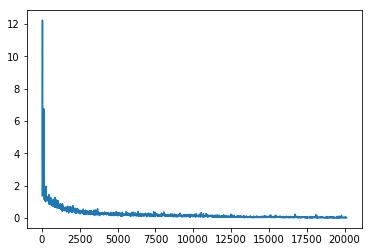

In [18]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

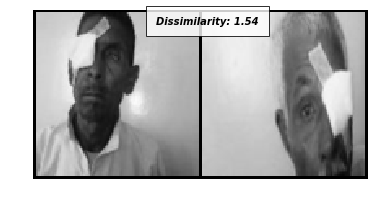

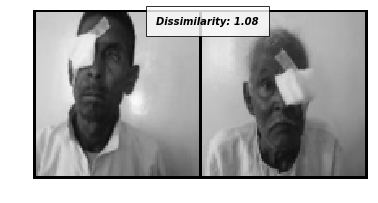

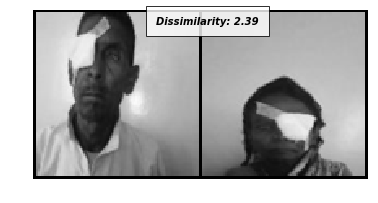

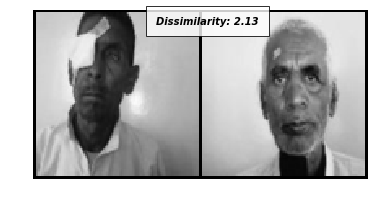

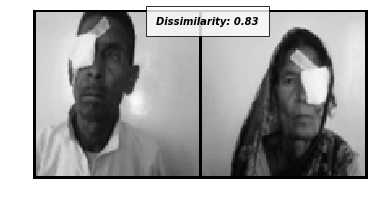

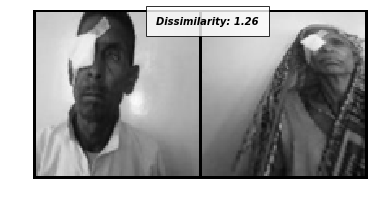

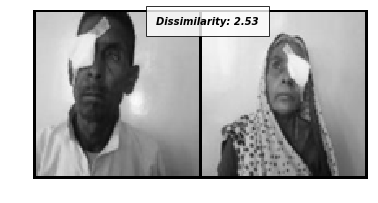

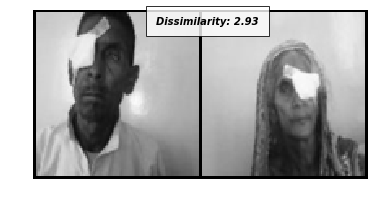

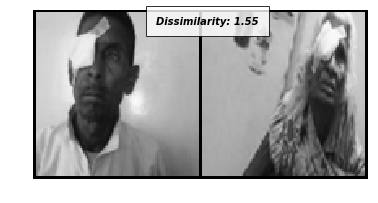

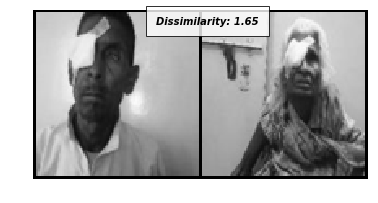

In [20]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0][0]))

